In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

DIR=r'data/maps/val'
training_data=[]

def train_data():
    for img in os.listdir(DIR):
        try:
            img_array=cv2.imread(os.path.join(DIR,img))
            training_data.append(img_array)
        except Exception as e:
            pass
train_data()
random.shuffle(training_data)

C:\Users\Manohar Vemuri\.conda\envs\main\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Manohar Vemuri\.conda\envs\main\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\Manohar Vemuri\.conda\envs\main\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
training_data=np.array(training_data)

In [3]:
sat_map=training_data[:,:,:600,:]
normal_map=training_data[:,:,600:,:]

In [4]:
# from skimage.transform import resize
# sat_map = resize(sat_map, (512, 512))
resized_sat_map=[]
resized_normal_map=[]
for sat_img in sat_map:
  sat_temp=cv2.resize(sat_img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
  sat_normalized=cv2.normalize(sat_temp, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  resized_sat_map.append(sat_normalized)

for normal_img in normal_map:
  normal_temp=cv2.resize(normal_img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
  normal_normalized=cv2.normalize(normal_temp, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  resized_normal_map.append(normal_normalized)
resized_sat_map=np.array(resized_sat_map)
resized_normal_map=np.array(resized_normal_map)

In [5]:
resized_sat_map.shape,resized_normal_map.shape

((1098, 256, 256, 3), (1098, 256, 256, 3))

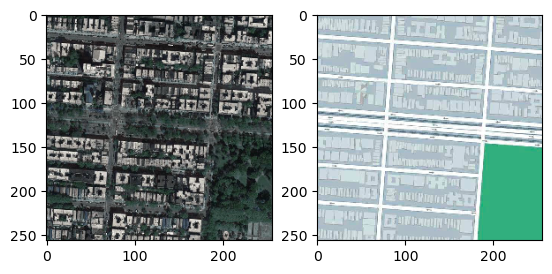

In [6]:
plt.subplot(121)
plt.imshow(resized_sat_map[2])
plt.subplot(122)
plt.imshow(resized_normal_map[2])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 32) 1536        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 32) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 64)   32768       leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

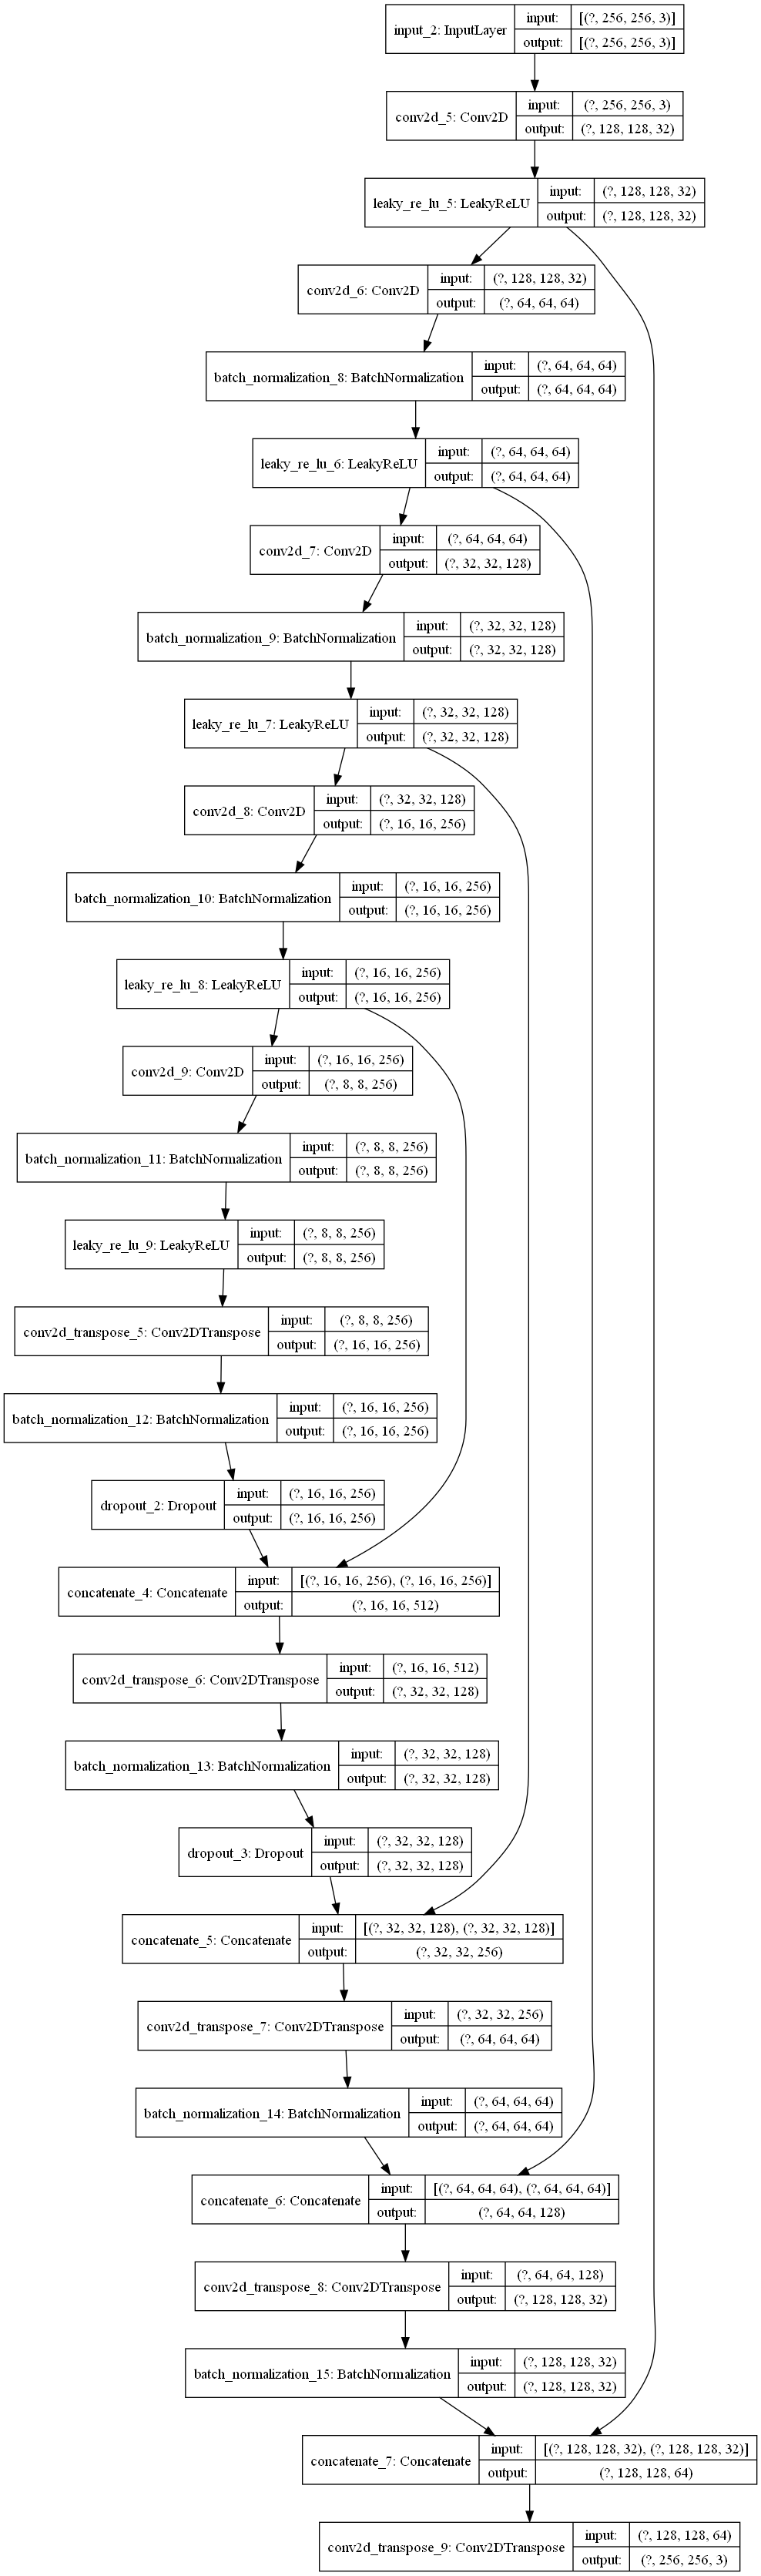

In [7]:
import tensorflow as tf
import numpy as np
generator=tf.keras.models.load_model('generator_model_image_translation.h5')
generator.summary()
tf.keras.utils.plot_model(generator,show_shapes=True)

In [8]:
aerial_pred=generator.predict(resized_sat_map,batch_size=128,steps=10)

In [10]:
aerial_pred.shape

(1098, 256, 256, 3)

In [ ]:
original_sat=resized_sat_map[0:10]
aerial_map=resized_normal_map[0:10]
img=aerial_pred[0:10]
fig=plt.figure(figsize=(20,20))
for i in range(10):
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(original_sat[i])
  plt.subplot(1,3,2)
  plt.imshow(aerial_map[i])
  plt.subplot(1,3,3)
  image1 = tf.keras.preprocessing.image.array_to_img(np.array(img[i]))
  plt.imshow(image1)
  plt.axis('off')
  plt.show()

In [11]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

87916544/87910968 [==============================] - 4s 0us/step


In [12]:
def compute_embeddings(dataloader, count):
    image_embeddings = []


    # for _ in tqdm(range(count)):
    #     images = next(iter(dataloader))
    embeddings = inception_model.predict(dataloader)


    image_embeddings.extend(embeddings)


    return np.array(image_embeddings)


count = 1096//128
real_image_embeddings = compute_embeddings(resized_normal_map, count)



generated_image_embeddings = compute_embeddings(aerial_pred, count)


real_image_embeddings.shape, generated_image_embeddings.shape


((1098, 2048), (1098, 2048))

In [13]:
from scipy import linalg
def calculate_fid(real_embeddings, generated_embeddings):
  # calculate mean and covariance statistics
  mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
  mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = linalg.sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid
fid = calculate_fid(real_image_embeddings, generated_image_embeddings)

In [14]:
print('FID Score:',fid)

FID Score: 355.31458565893865
